In [154]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import TradePosition
import TouchArea
import TradingStrategy
import TouchDetection

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)
importlib.reload(TradingStrategy)
importlib.reload(TouchDetection)

from TradePosition import TradePosition
from TouchArea import TouchArea
from TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from TouchDetection import BacktestTouchDetectionParameters, calculate_touch_detection_area, plot_touch_detection_areas, np_mean, np_median

In [155]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "AAPL" #
# symbol = "TJX"
# symbol = "JNJ" #
symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA" #
# symbol = "TJX" #


# start_date = "2023-01-01 00:00:00"
# end_date =   "2024-01-01 00:00:00"

# start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"

start_date = "2024-08-21 00:00:00"
end_date =   "2024-08-22 00:00:00"

# Usage example:
touch_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    atr_period=15,
    level1_period=15,
    multiplier=1.4,
    min_touches=3,
    start_time=None,
    end_time='16:00',
    use_median=True,
    touch_area_width_agg=np_median,
    use_saved_bars=True,
    rolling_avg_decay_rate=0.85,
    # export_bars_path=f'bars/bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='16:00', \
#     use_median=True, touch_area_width_agg=np_median, use_saved_bars=True, export_bars_path=f'bars_{symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


                                    open    high       low     close  volume  \
symbol timestamp                                                               
AMZN   2024-08-21 04:00:00-04:00  178.99  178.99  178.9900  178.9900   585.0   
       2024-08-21 04:01:00-04:00  178.99  178.99  178.9900  178.9900     0.0   
       2024-08-21 04:02:00-04:00  178.99  178.99  178.9900  178.9900     0.0   
       2024-08-21 04:03:00-04:00  178.99  178.99  178.9900  178.9900     0.0   
       2024-08-21 04:04:00-04:00  178.99  178.99  178.9900  178.9900     0.0   
...                                  ...     ...       ...       ...     ...   
       2024-08-21 19:55:00-04:00  180.25  180.25  180.2200  180.2200  1095.0   
       2024-08-21 19:56:00-04:00  180.25  180.25  180.2200  180.2200     0.0   
       2024-08-21 19:57:00-04:00  180.23  180.23  180.2003  180.2003   807.0   
       2024-08-21 19:58:00-04:00  180.23  180.23  180.2000  180.2100  1702.0   
       2024-08-21 19:59:00-04:00  180.25

100%|██████████| 1/1 [00:00<00:00, 29.38it/s]


In [156]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [157]:
# zoom_start_date = start_date
# zoom_end_date = end_date
# zoom_start_date = "2024-08-21 14:30:00"
# zoom_end_date =   "2024-08-21 15:00:00"
# plot_touch_detection_areas(touch_detection_areas)
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [158]:
len(touch_detection_areas.long_touch_area) + len(touch_detection_areas.short_touch_area)

261

AMZN is marginable.
AMZN is shortable and ETB.


100%|██████████| 387/387 [00:00<00:00, 406.20it/s]


END
Strategy: Long&Short
AMZN is marginable.
AMZN is shortable and ETB.
2024-08-21 09:30:00-04:00 -> 2024-08-21 15:57:00-04:00

Overall Statistics:
Initial Investment: 10000
Final Balance:      10295.2734
Balance % change:   2.9527% ***
Baseline % change:  -0.1053%
Number of Trades Executed: 31

Total Profit/Loss (including fees): $295.2734
  Total Profit: $435.4274
  Total Loss:   $-140.1540
Total Transaction Costs: $16.7005

Borrow Fees: $0.0526
Average Profit/Loss per Trade (including fees): $9.5249

Detailed Trade Statistics:
Statistic       count    mean     std     min     25%     50%     75%     max
Trade Category                                                               
All                31  0.0953  0.3120 -0.1617 -0.0736 -0.0391  0.1341  1.2791
Win                12  0.3607  0.3702  0.0076  0.0980  0.2087  0.5805  1.2791
Lose               19 -0.0724  0.0435 -0.1617 -0.1029 -0.0588 -0.0453 -0.0012
Lwin                4  0.2772  0.2211  0.0963  0.1513  0.2083  0.3342  0.5

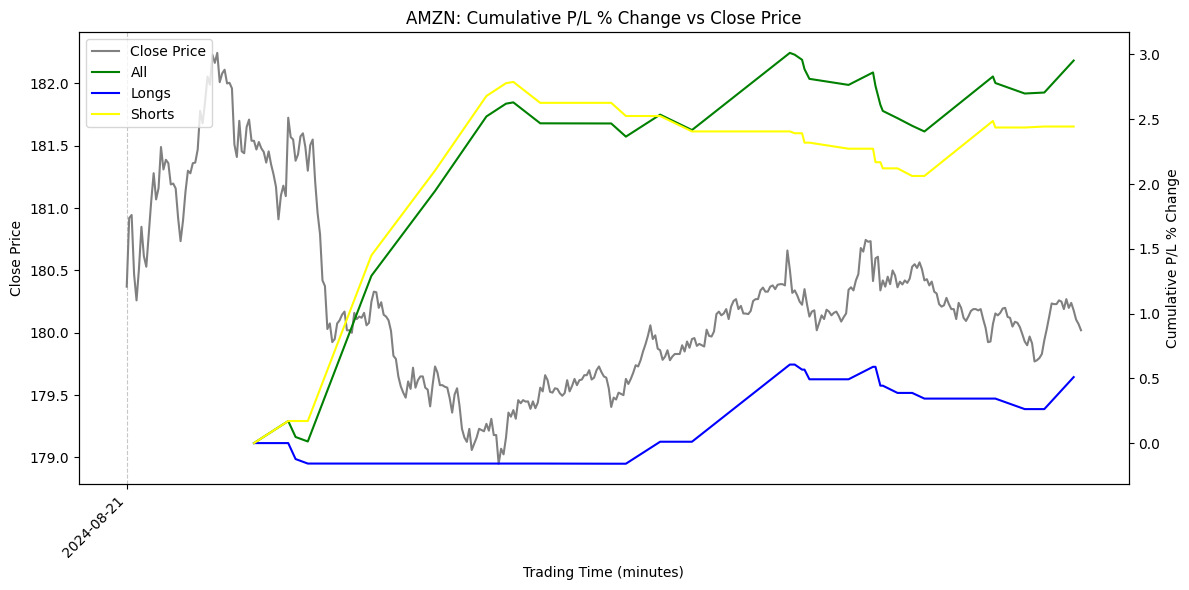

In [159]:
params = StrategyParameters(
    initial_investment=10_000,
    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    times_buying_power=1,
    
    soft_start_time = None, 
    soft_end_time = '15:50',
    
    # slippage_factor=0
)

strategy = TradingStrategy(touch_detection_areas, params, export_trades_path='trades_output.csv')
results = strategy.run_backtest()

In [7]:
# symbols = ['AAPL','INTC','JNJ','TSLA','MSFT','AMZN','ABBV']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['NVDA', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT']
# symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'BAC', 'META', 'T', 'VZ', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # generally high-liquidity from 2016 to present
symbols = ['AAPL', 'MSFT', 'NVDA', 'INTC', 'AMZN', 'TSLA', 'DIS', 'JPM', 'BAC', 'GOOGL', 'FB', 'XOM', 'CVX', 'JNJ', 'PFE', 'KO'] # test3. generally high-liquidity from 2016 to 2019

In [22]:
trades_folder = 'test4/trades'
graphs_folder = 'test4/graphs'
xbp_folder = 'test4/xbp'

from IPython.utils import io
for s in symbols:
    touch_params.symbol = s
    touch_params.export_bars_path=f'bars/bars_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    
    # print(touch_params.symbol)
    # print(touch_params.export_bars_path)
    results_list = []
    
    # print(touch_params)
    touch_detection_areas = calculate_touch_detection_area(touch_params)
    # continue
    for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
        
        params.times_buying_power = i
        with io.capture_output() as captured:
            strategy = TradingStrategy(touch_detection_areas, params)
            
            if i == 1:
                strategy.export_trades_path=f'{trades_folder}/trades_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
                strategy.export_graph_path=f'{graphs_folder}/graph_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.png'
            
            balance, longs_executed, shorts_executed, balance_change, mean_profit_loss_pct, win_mean_profit_loss_pct, lose_mean_profit_loss_pct, winrate, total_costs, \
                avg_sub_pos, avg_transact, count_entry_adjust, count_entry_skip, count_exit_adjust, count_exit_skip, key_stats = \
                strategy.run_backtest()

        trades_executed = longs_executed + shorts_executed
        newrow = {
            'xBP': i,
            'net%': balance_change,
            'balance': balance,
            'cnt': trades_executed,
            # 'AvgPL%': mean_profit_loss_pct,
            # 'winAvgPL%': win_mean_profit_loss_pct,
            # 'loseAvgPL%': lose_mean_profit_loss_pct,
            'WR%': winrate,
            'TotalCosts': total_costs,
            # 'avg sub pos created': avg_sub_pos,
            # 'avg transactions': avg_transact,
            'entryAdjust': count_entry_adjust,
            'entrySkip': count_entry_skip,
            'exitAdjust': count_exit_adjust,
            'exitSkip': count_exit_skip,
            **key_stats
        }
        results_list.append(newrow)

    results = pd.DataFrame(results_list)
    # Format specific columns if needed
    results['xBP'] = results['xBP'].map('{:.1f}'.format)
    results['balance'] = results['balance'].map('${:.4f}'.format)
    results['TotalCosts'] = results['TotalCosts'].map('${:.4f}'.format)

    # Format all float columns
    float_columns = results.select_dtypes(include=['float64']).columns
    results[float_columns] = results[float_columns].applymap('{:.4f}'.format)

    # Display the results
    # pd.set_option('display.max_columns', None)
    filename = f'{xbp_folder}/xbp_{touch_params.symbol}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    results.to_csv(filename,index=False)
    # results

Saved bars to bars/bars_AAPL_2024-08-21_2024-08-22.zip
                                      open      high     low   close  volume  \
symbol timestamp                                                               
AAPL   2024-08-21 04:00:00-04:00  225.8900  226.4700  225.89  226.47  2480.0   
       2024-08-21 04:01:00-04:00  225.8900  226.4700  225.89  226.47     0.0   
       2024-08-21 04:02:00-04:00  225.8900  226.4700  225.89  226.47     0.0   
       2024-08-21 04:03:00-04:00  226.8500  226.8500  226.85  226.85   773.0   
       2024-08-21 04:04:00-04:00  226.8900  226.8900  226.89  226.89   286.0   
...                                    ...       ...     ...     ...     ...   
       2024-08-21 19:55:00-04:00  226.6700  226.6700  226.67  226.67     0.0   
       2024-08-21 19:56:00-04:00  226.6700  226.6700  226.67  226.67     0.0   
       2024-08-21 19:57:00-04:00  226.6100  226.6500  226.61  226.65   321.0   
       2024-08-21 19:58:00-04:00  226.6044  226.6892  226.60  226

 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

In [ ]:
# symbols = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'JPM', 'GOOGL', 'META', 'XOM', 'CVX', 'UNH', 'PFE', 'KO', 'PG', 'BA', 'CAT','INTC','JNJ','ABBV'] # test2

In [ ]:
results_combined = pd.DataFrame()
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    results['symbol'] = s
    first_column = results.pop('symbol') 
    results.insert(0, 'symbol', first_column) 
    results_combined = pd.concat([results_combined, results],ignore_index=True)
results_combined['WinMax'] = results_combined[['LwinMax', 'SwinMax']].max(axis=1)
results_combined['LoseMin'] = results_combined[['LloseMin', 'SloseMin']].max(axis=1)
pd.set_option('display.max_rows', results_combined.shape[0])
pd.set_option('display.max_columns', results_combined.shape[1])
results_combined.loc[results_combined.xBP.isin({1,4})].sort_values('net%',ascending=False)

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results.AllAvg.astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['net%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

In [ ]:
for s in symbols:
    fname = f'{xbp_folder}/xbp_{s}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
    results = pd.read_csv(fname)
    plt.plot(results.xBP.astype(float).to_list(), results['WR%'].astype(float).to_list(), label=s)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()